## Business Understanding

Choose stakeholder and figure out what they care about

- need two important parameter estimates as recommendations


## Exploratory Data Analysis

How/why does this data allow you to answer your questions?

**Data Visualization**
- Need 3 High Quality Data Visualizations

## Data Prep/Feature Eng

**Train/Test/Split**

**General Data Preparation**
- Nulls/dupes/outliers
- scaling
- transformations (for linearity)

**Feature Engineering**
- Encoding Variables (categories)
- Polynomial Features
- Interaction Terms
- NEED ONE NON-NUMERIC FEATURE

## Iterative Modeling

First try simplest approach.

Consider what the model baseline is

Start Adding Complexity and compare along the way
(**DOCUMENT THE ITERATIVE PROCESS**)

Models need to adhere to the assumptions of linear regression. If models do not adhere need to at least show that assumptions were tested for:

**ASSUMPTIONS**
- linear relationship between x and y - Heatmaps, scatter matrix
- low multicollinearituy - heatmaps, scatter matrix, VIF
- normal distribution of errors - kde, histogram, QQ-Plot, quantitative check (Jarque-Bera)
- homoskedasticity between errors - scatter plot between true and expected value

## Model Interpretation

Check for statistical Significance - check p-values of input variables

Are coefficients interpretable

Check R2, RMSE, MAE, MSE and other regression metrics

-----------------------


## STAKEHOLDER SELECTION

Stakeholder is Redfin

- Develop model to determine optimal purchasing price of homes and what renovations to make that will lead to greatest ROI


## BUSINESS UNDERSTANDING

**70% Rule:**

$$ 
MBP = (0.7ARV) - ERC
$$

where:

MBP = Maximum Buying Price

ARV = After-repair value

ERC = Estimated repair costs

in a sellers market we can adjust 70% to as high as 85%

## DATA EXPLORATION

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import statsmodels
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from statsmodels.tools.eval_measures import rmse
from statsmodels.api import qqplot
from folium.plugins import FastMarkerCluster
import folium

In [3]:
num_features_to_select = 3
latitude_condition = False

# Use RSE or use manual formula string
use_RSE = True
formula_string = 'sqft_living'

In [4]:
df = pd.read_csv('data/cleaned_data.csv')
df = df[df['yr_built'] > 1930]
df.drop(['id','date','Unnamed: 0','yr_renovated'],axis=1,inplace=True)
df.reset_index(drop=True,inplace=True)
if latitude_condition:
    df = df[df['lat']< df['lat'].mean()]

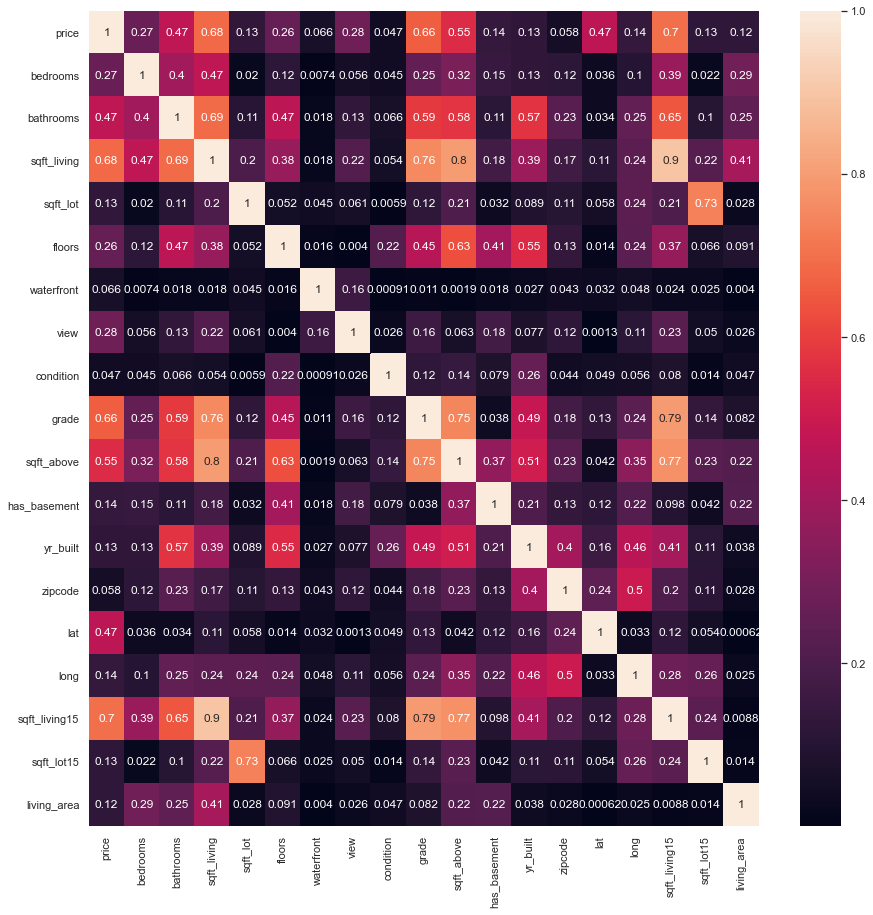

In [5]:
sns.set(rc={'figure.figsize':(15, 15)})

# Use the .heatmap method to depict the relationships visually!
sns.heatmap(df.corr().abs(),annot=True);

In [17]:
# Shows base dataset corrs
df_base = pd.read_csv('data/cleaned_data.csv')
df_base.drop(['id','date','yr_renovated'],axis=1,inplace=True)
df_base_corrs = df_base.corr()['price'].map(abs).sort_values(ascending=False)
df_base_corrs[:5]

price            1.000000
sqft_living15    0.642815
sqft_living      0.639537
grade            0.622257
sqft_above       0.509719
Name: price, dtype: float64

In [43]:
lat = 47.55
long = -122.2

my_map = folium.Map([lat, long], zoom_start=10)

top_coordinates = [
    # Above Seattle 
    [47.777799, -122.419374],
    [47.664592, -122.419374],
    [47.664592, -121.966095],
    [47.777799, -121.966095],
    [47.777799, -122.419374],
] 
right_coordinates = [
    # Right-side of Seattle
    [47.664592, -121.966095],
    [47.510590, -121.966095],
    [47.510590, -122.151067]
]
coordinates = [
    # Seattle
    [47.473347, -122.151067],
    [47.664592, -122.151067],
    [47.664592, -122.419374],
    [47.473347, -122.419374],
    
    # Below Seattle
    [47.473347, -122.151067],
    [47.304134, -122.151067],
    [47.304134, -122.419374],
    [47.473347, -122.419374],
    [47.473347, -122.151067]
]
my_PolyLine = folium.PolyLine(locations = right_coordinates, weight = 5)
my_map.add_child(my_PolyLine)
my_PolyLine = folium.PolyLine(locations = top_coordinates, weight = 5)
my_map.add_child(my_PolyLine)
my_PolyLine=folium.PolyLine(locations=coordinates,weight=5)
my_map.add_child(my_PolyLine)
# add all the point from the file to the map object using FastMarkerCluster
my_map.add_child(FastMarkerCluster(df_base[['lat', 'long']].values.tolist()))

In [19]:
# Shows cleaned dataset corrs
df_corrs = df.corr()['price'].map(abs).sort_values(ascending=False)
df_corrs[:5]

price            1.000000
sqft_living15    0.695505
sqft_living      0.684201
grade            0.662801
sqft_above       0.551489
Name: price, dtype: float64

In [27]:
# Delete the comment from the quadrant and change 
# X_train, X_test, y_train, y_test = train_test_split(df.drop('price', axis=1), df['price'], test_size=0.2, random_state=42)
# to
# X_train, X_test, y_train, y_test = train_test_split(df_quad.drop('price', axis=1), df_quad['price'], test_size=0.2, random_state=42)

# df_seattle = df[(df['lat'] > 47.473347) & (df['lat'] < 47.664592)  & (df['long'] < -122.151067) & (df['long'] > -122.419374)]
# df_bottom = df[(df['lat'] > 47.304134) & (df['lat'] < 47.473347)  & (df['long'] < -122.151067) & (df['long'] > -122.419374)]
# df_top = df[(df['lat'] > 47.664592) & (df['lat'] < 47.777799)  & (df['long'] < -121.966095) & (df['long'] > -122.419374)]
# df_right = df[(df['lat'] > 47.510590) & (df['lat'] < 47.664592)  & (df['long'] < -121.966095) & (df['long'] > -122.151067)]

In [36]:
# Create Train and Test Datasets
X_train, X_test, y_train, y_test = train_test_split(df.drop('price', axis=1), df['price'], test_size=0.2, random_state=42)

In [31]:
# Fit Scalar to Train
ss = StandardScaler()
ss.fit(X_train)

# Transform both Train and Test
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

In [32]:
# Recursive Feature Selection
lr_rfe = LinearRegression()
select = RFE(lr_rfe, n_features_to_select=num_features_to_select)
select.fit(X=X_train_scaled, y=y_train)


keep_list = [(k,v) for k,v in zip(df.drop('price', axis=1).columns,select.support_)]
keep_string = ''
for k,v in keep_list:
    if v:
        keep_string += k + '+'
keep_string = keep_string[:-1]

In [33]:
# Creates scaled features dataframe and then adds on price column

# Train
X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.columns = df.drop('price', axis=1).columns
y_train.reset_index(drop=True,inplace=True)
X_train_scaled_final = pd.concat((X_train_scaled,y_train),axis=1)

# Test
X_test_scaled = pd.DataFrame(X_test_scaled)
X_test_scaled.columns = df.drop('price', axis=1).columns
y_test.reset_index(drop=True,inplace=True)
X_test_scaled_final = pd.concat((X_test_scaled,y_test),axis=1)

In [34]:
# Baseline Model
baseline_mean = X_train_scaled_final['price'].mean()
model_base = DummyRegressor(strategy='mean', constant=baseline_mean)
baseline_mean

504490.35204359674

In [35]:
if use_RSE:
    formula = f'price ~ {keep_string}'
else:
    formula = f'price ~ {formula_string}'
model = ols(formula,X_train_scaled_final).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     1993.
Date:                Mon, 04 Oct 2021   Prob (F-statistic):               0.00
Time:                        17:40:15   Log-Likelihood:                -24068.
No. Observations:                1835   AIC:                         4.814e+04
Df Residuals:                    1831   BIC:                         4.817e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5.045e+05   2809.071    179.593      0.000    4.99e+05     5.1e+05
grade           5.71e+04   4454.261     12.819      0.000    4.84e+04    6.58e+04
lat            9.671e+04   3119.198     31.005      0.000    9.06e+04    1.03e+05
sqft_living15  1.101e+05   4363.930     25.234      0.000    1.02e+05    1.19e+05
==============================================================================
Omnibus:                       98.195   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              127.530
Skew:                           0.509   Prob(JB):                     2.03e-28
Kurtosis:                       3.794   Cond. No.                         2.96
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
model_test = ols(formula,X_test_scaled_final).fit()
model_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     1330.
Date:                Mon, 04 Oct 2021   Prob (F-statistic):               0.00
Time:                        17:34:54   Log-Likelihood:                -28064.
No. Observations:                2139   AIC:                         5.614e+04
Df Residuals:                    2135   BIC:                         5.616e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    4.554e+05   2613.885    174.238      0.000     4.5e+05    4.61e+05
sqft_living  7.921e+04   4051.142     19.553      0.000    7.13e+04    8.72e+04
grade        6.357e+04   3996.854     15.905      0.000    5.57e+04    7.14e+04
lat            7.7e+04   2620.056     29.388      0.000    7.19e+04    8.21e+04
==============================================================================
Omnibus:                      362.358   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              718.414
Skew:                           1.014   Prob(JB):                    9.96e-157
Kurtosis:                       4.987   Cond. No.                         2.81
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## MODEL VALIDATION

### Check Normal Distribution of Input Variables

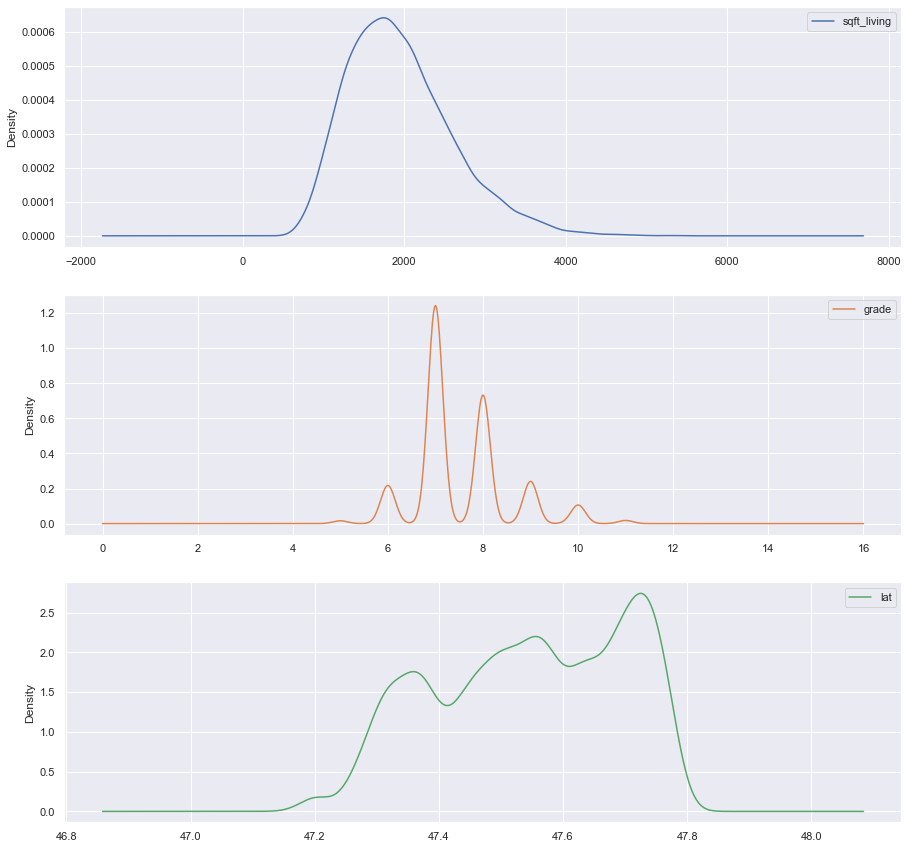

In [16]:
df.filter([x[0] for x in keep_list if x[1] == True],axis=1).plot.kde(subplots=True,sharex=False)
plt.show()

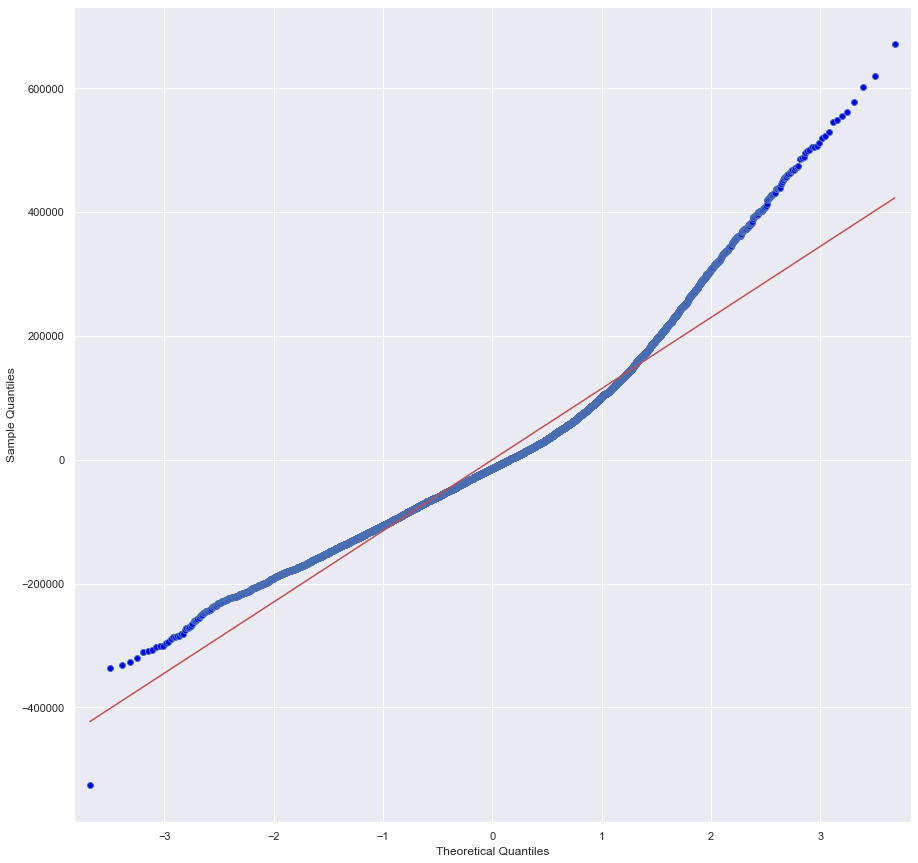

In [17]:
y_hat_train = model.predict(X_train_scaled)
y_hat_test = model_test.predict(X_test_scaled)

qqplot(y_train-y_hat_train,line='r')
plt.show()

### Checking for Heteroskedasticity and Lack of Trend in Errors

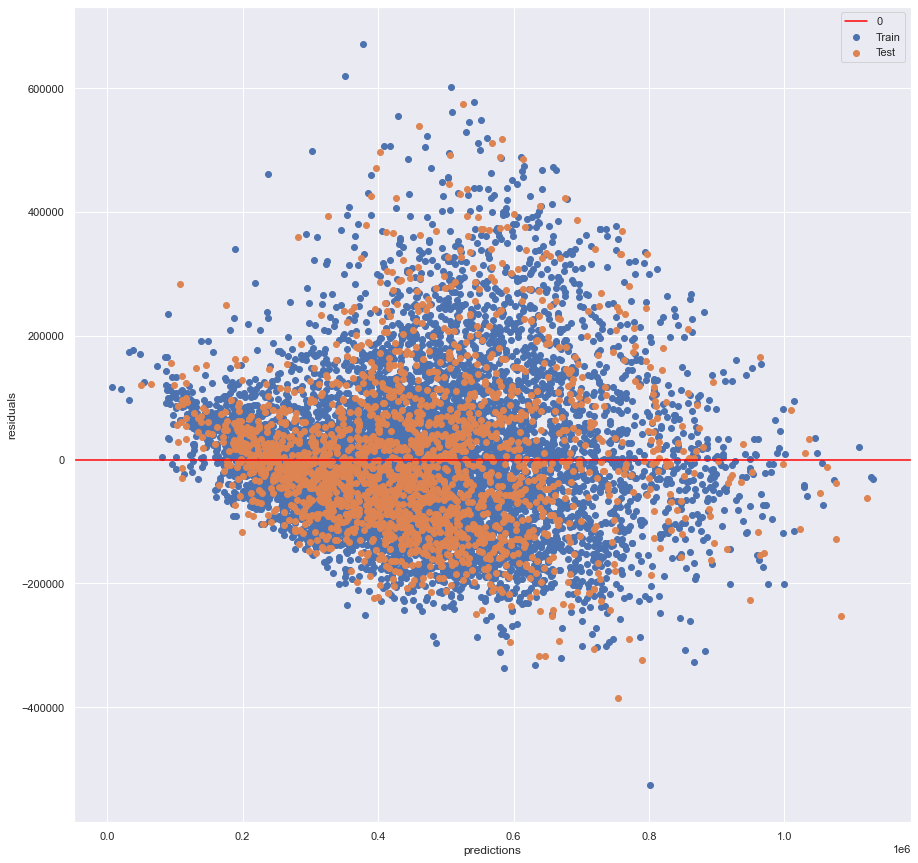

In [18]:
plt.scatter(y_hat_train, y_train - y_hat_train, label='Train')
plt.scatter(y_hat_test, y_test - y_hat_test, label='Test')

plt.axhline(y=0, color = 'red', label = '0')
plt.xlabel('predictions')
plt.ylabel('residuals')
plt.legend()
plt.show()

### Checking Mean Squared Error

In [19]:
print('TRAIN MSE:',rmse(y_train,y_hat_train))
print('TEST MSE:',rmse(y_test,y_hat_test))
print('MSE DIFF:', abs(rmse(y_train,y_hat_train)-rmse(y_test,y_hat_test)))

TRAIN MSE: 117869.88259654623
TEST MSE: 120723.51339021497
MSE DIFF: 2853.630793668737


### Checking Linearity and Multicollinearity

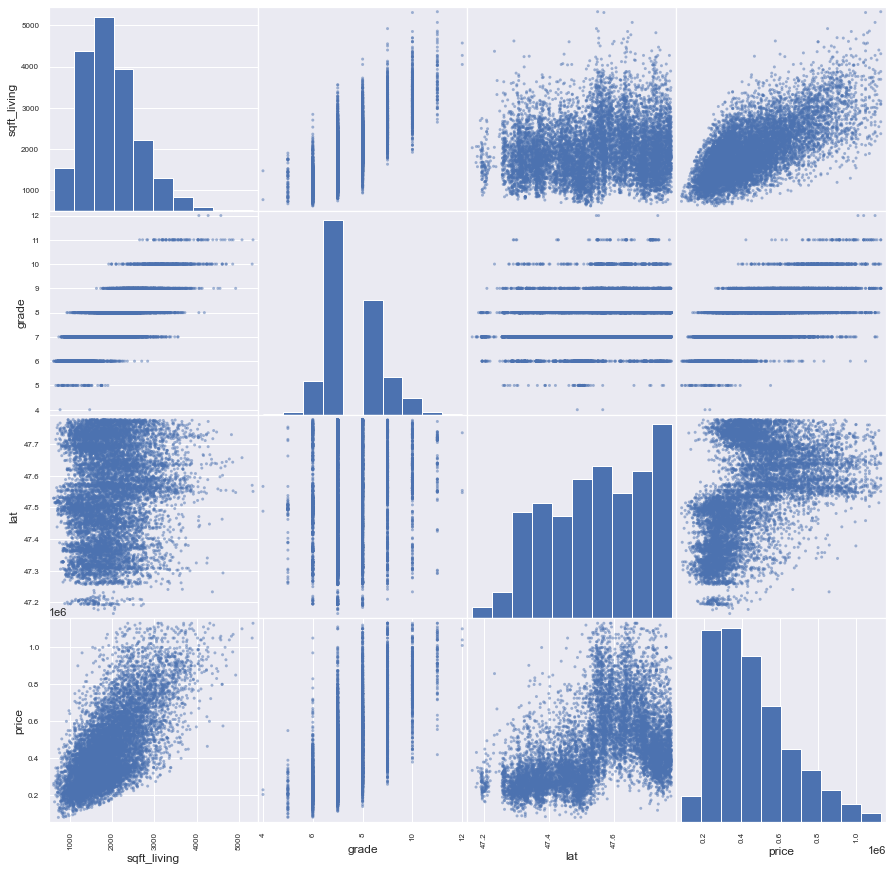

In [20]:
scatter_keep_list = keep_list.copy()
scatter_keep_list.append(('price',True))
pd.plotting.scatter_matrix(df.filter([x[0] for x in scatter_keep_list if x[1] == True],axis=1))
plt.show()

In [21]:
X_train_scaled_final.filter([x[0] for x in scatter_keep_list if x[1] == True],axis=1).corr().abs()['price'].sort_values(ascending=True)

lat            0.471160
grade          0.662651
sqft_living    0.685224
price          1.000000
Name: price, dtype: float64

<AxesSubplot:>

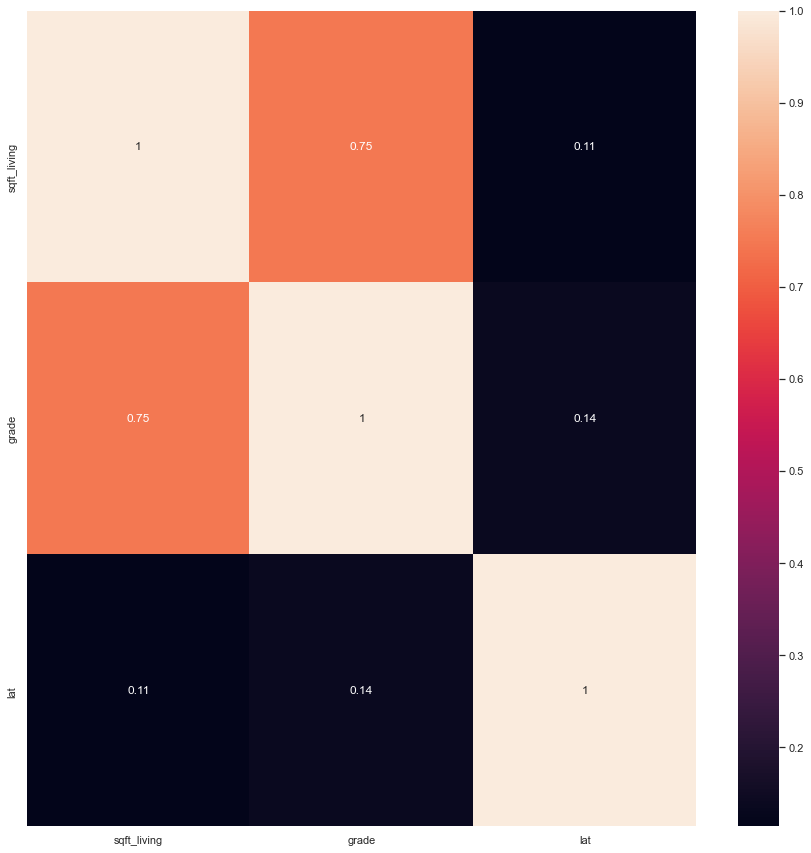

In [22]:
sns.heatmap(X_train_scaled.filter([x[0] for x in scatter_keep_list if x[1] == True],axis=1).corr().abs(),annot=True)